In [193]:
import numpy as np
import pandas as pd

In [194]:
from datetime import datetime

In [195]:
df = pd.read_csv("E:/Userfiles/Download/archive (2)/NIFTY50_all.csv")
df

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2007-11-27,MUNDRAPORT,EQ,440.00,770.00,1050.00,770.00,959.00,962.90,984.72,27294366,2.687719e+15,NaN,9859619.0,0.3612
1,2007-11-28,MUNDRAPORT,EQ,962.90,984.00,990.00,874.00,885.00,893.90,941.38,4581338,4.312765e+14,NaN,1453278.0,0.3172
2,2007-11-29,MUNDRAPORT,EQ,893.90,909.00,914.75,841.00,887.00,884.20,888.09,5124121,4.550658e+14,NaN,1069678.0,0.2088
3,2007-11-30,MUNDRAPORT,EQ,884.20,890.00,958.00,890.00,929.00,921.55,929.17,4609762,4.283257e+14,NaN,1260913.0,0.2735
4,2007-12-03,MUNDRAPORT,EQ,921.55,939.75,995.00,922.00,980.00,969.30,965.65,2977470,2.875200e+14,NaN,816123.0,0.2741
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235187,2021-04-26,ZEEL,EQ,188.00,190.60,191.10,185.10,186.70,186.40,187.35,8542755,1.600451e+14,52374.0,2340188.0,0.2739
235188,2021-04-27,ZEEL,EQ,186.40,188.00,192.95,186.80,188.80,188.15,189.41,14247767,2.698636e+14,73673.0,5425957.0,0.3808
235189,2021-04-28,ZEEL,EQ,188.15,188.80,190.60,187.10,188.95,189.10,188.85,8429439,1.591917e+14,44056.0,2413974.0,0.2864
235190,2021-04-29,ZEEL,EQ,189.10,190.80,191.65,186.00,186.60,186.55,187.44,9483009,1.777471e+14,60932.0,2744472.0,0.2894


In [196]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235192 entries, 0 to 235191
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Date                235192 non-null  object 
 1   Symbol              235192 non-null  object 
 2   Series              235192 non-null  object 
 3   Prev Close          235192 non-null  float64
 4   Open                235192 non-null  float64
 5   High                235192 non-null  float64
 6   Low                 235192 non-null  float64
 7   Last                235192 non-null  float64
 8   Close               235192 non-null  float64
 9   VWAP                235192 non-null  float64
 10  Volume              235192 non-null  int64  
 11  Turnover            235192 non-null  float64
 12  Trades              120344 non-null  float64
 13  Deliverable Volume  219115 non-null  float64
 14  %Deliverble         219115 non-null  float64
dtypes: float64(11), int64(1), object(3

In [197]:
df1=df.iloc[:1000, :]

In [198]:
train_dates = pd.to_datetime(df1['Date'])
print(train_dates)

0     2007-11-27
1     2007-11-28
2     2007-11-29
3     2007-11-30
4     2007-12-03
         ...    
995   2011-12-09
996   2011-12-12
997   2011-12-13
998   2011-12-14
999   2011-12-15
Name: Date, Length: 1000, dtype: datetime64[ns]


In [199]:
cols = list(df1)[3:9]
#Date and volume columns are not used in training. 
print(cols)

['Prev Close', 'Open', 'High', 'Low', 'Last', 'Close']


In [200]:
df_for_training = df1[cols].astype(float)

In [201]:
#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [202]:
#Empty lists to be populated using formatted training data
trainX = []
trainY = []


In [203]:
n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 14  # Number of past days we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)


In [204]:
print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (986, 14, 6).
trainY shape == (986, 1).


In [205]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout

In [206]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

In [207]:
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 14, 64)            18176     
                                                                 
 lstm_5 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 30,625
Trainable params: 30,625
Non-trainable params: 0
_________________________________________________________________


In [208]:
history = model.fit(trainX, trainY, epochs=5, batch_size=16, validation_split=0.1, verbose=1)

Epoch 1/5
56/56 [==============================] - 10s 43ms/step - loss: 0.3392 - val_loss: 0.0067
Epoch 2/5
56/56 [==============================] - 1s 26ms/step - loss: 0.0797 - val_loss: 0.0100
Epoch 3/5
56/56 [==============================] - 1s 26ms/step - loss: 0.0721 - val_loss: 0.0060
Epoch 4/5
56/56 [==============================] - 1s 25ms/step - loss: 0.0632 - val_loss: 0.0038
Epoch 5/5
56/56 [==============================] - 1s 25ms/step - loss: 0.0504 - val_loss: 0.0091


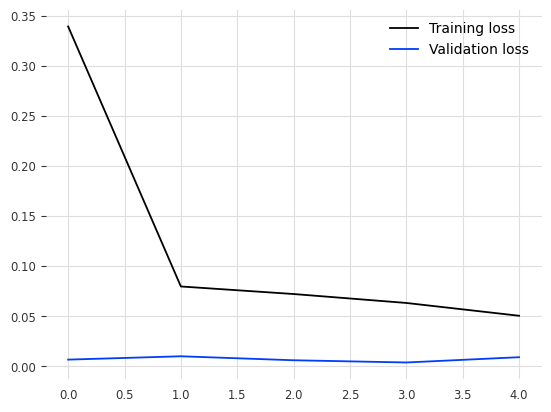

In [209]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [233]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())

In [418]:
n_future = 300 #predicting for next 90 days

predict_period_dates = pd.date_range(list(train_dates)[-1], periods=n_future, freq=us_bd).tolist()
print(predict_period_dates)

[Timestamp('2011-12-15 00:00:00', freq='C'), Timestamp('2011-12-16 00:00:00', freq='C'), Timestamp('2011-12-19 00:00:00', freq='C'), Timestamp('2011-12-20 00:00:00', freq='C'), Timestamp('2011-12-21 00:00:00', freq='C'), Timestamp('2011-12-22 00:00:00', freq='C'), Timestamp('2011-12-23 00:00:00', freq='C'), Timestamp('2011-12-27 00:00:00', freq='C'), Timestamp('2011-12-28 00:00:00', freq='C'), Timestamp('2011-12-29 00:00:00', freq='C'), Timestamp('2011-12-30 00:00:00', freq='C'), Timestamp('2012-01-03 00:00:00', freq='C'), Timestamp('2012-01-04 00:00:00', freq='C'), Timestamp('2012-01-05 00:00:00', freq='C'), Timestamp('2012-01-06 00:00:00', freq='C'), Timestamp('2012-01-09 00:00:00', freq='C'), Timestamp('2012-01-10 00:00:00', freq='C'), Timestamp('2012-01-11 00:00:00', freq='C'), Timestamp('2012-01-12 00:00:00', freq='C'), Timestamp('2012-01-13 00:00:00', freq='C'), Timestamp('2012-01-17 00:00:00', freq='C'), Timestamp('2012-01-18 00:00:00', freq='C'), Timestamp('2012-01-19 00:00:00'

In [419]:
prediction = model.predict(trainX[-n_future:]) #shape = (n, 1) where n is the n_days_for_prediction

10/10 [==============================] - 0s 4ms/step


In [420]:
#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]

In [421]:
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Open':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

In [422]:
original = df1[['Date', 'Open']]
original['Date']=pd.to_datetime(original['Date'])


In [423]:
import seaborn as sns

<AxesSubplot:xlabel='Date', ylabel='Open'>

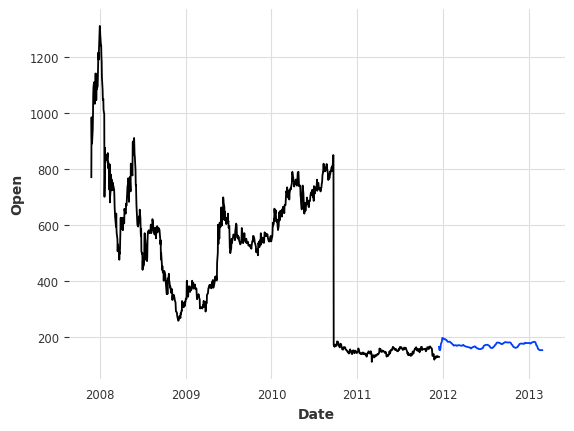

In [424]:
sns.lineplot(original['Date'], original['Open'])
sns.lineplot(df_forecast['Date'], df_forecast['Open'])